### Imports et initialisations

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import random
import re
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

##### Récupération des tweets

In [3]:
with open("clean_dataset", "r") as file:
    lines = file.readlines()
    
clean_sample = [line.split() for line in lines]

with open("dataset", "r") as file:
    raw_sample = file.readlines()

### Récupération des différents mots et de leur nombre d'occurences

Pour interpréter les résultats nous aurons besoin de connaître les mots les plus utilisés dans chaque cluster

Pour cela nous utilisons ces fonctions qui permettent d'obtenir une liste des mots du jeu de données (ou d'un sous ensemble comme ce sera le cas avec les clusters) triés par nombre d'occurences décroissant

In [4]:
#Création du dictionnaire de mots avec leur occurence
def create_wdict(lines):
    dico = {}
    for msg in lines:
        for mot in msg:
            if mot in dico: 
                dico[mot] += 1
            else:
                dico[mot] = 1
    return dico

#Création de la liste des mots triée par nombre d'occurences décroissant
def create_sorted_wlist(lines):
    dico = create_wdict(lines)
    wlist = [ (mot, dico[mot]) for mot in dico.keys()]
    return sorted(wlist, key = lambda mot: mot[1], reverse = True)

In [5]:
#dico = create_wdict(sample)

liste_mots_triee = create_sorted_wlist(clean_sample)

print("Il y a {} mots différents".format(len(liste_mots_triee)))
dict_len = len(liste_mots_triee) + 4
print("Les dix mots les plus utilisés sont :")
for mot in liste_mots_triee[1:10]:
    print(mot[0], end=' ')

Il y a 62554 mots différents
Les dix mots les plus utilisés sont :
aller sale français noir pouvoir voir bien fils vouloir 

### Encodage à l'aide d'un modèle word2vec entraîné avec les données

On charge le modèle depuis le disque

In [32]:
from gensim.models import Doc2Vec

In [33]:
d2v = Doc2Vec.load("doc2v_model")

In [34]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([d2v.infer_vector(tweet) for tweet in clean_sample])

CPU times: user 24.6 s, sys: 16.5 ms, total: 24.6 s
Wall time: 24.6 s


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode PCA

In [35]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 3.38 s, sys: 4.33 s, total: 7.72 s
Wall time: 1.1 s


In [36]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)

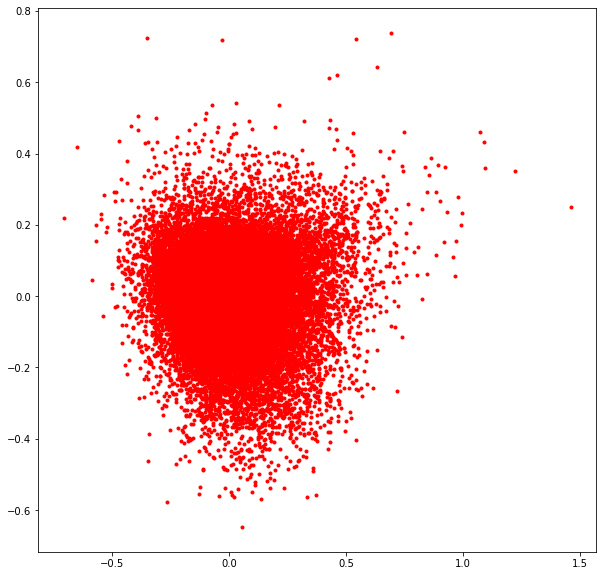

In [37]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

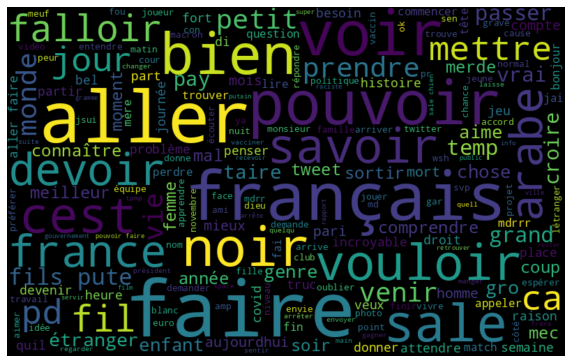

In [12]:
from wordcloud import WordCloud
all_words = ' '.join([" ".join(text) for text in clean_sample])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Fonctions pour la visualisation des clusters

Les algorithmes de classification renvoient une liste de la taille de notre dataset. Chaque élément de cette liste correspond au numéro de cluster auquel le message du même indice de notre jeu de données est associé.

Pour interpréter les résultats on a besoin de connaître les messages de chaque clusters on définit donc quelques fonctions qui vont nous permettre de manipuler les données :

- Une fonction qui construit un dictionnaire qui a chaque cluster associe la liste des indices des messages correspondants
- Une fonction qui construit la liste des mots et la liste des messages de chaque cluster.
- Une fonction qui affiche le nombre de messages pour chaque cluster
- Une fonction qui affiche pour chaque cluster la liste des n mots les plus utilisés
- Une fonction qui affiche un échantillon de messages pour chaque cluster
- Une fonction qui permet de visualiser les données catégorisées
- Et une fonction qui fait tout ça à la fois !

In [38]:
#Construire le dictionnaire des résultats qui à chaque cluster associe la liste indices des messages correspondants

def build_res_dict(pred):
    res = {}
    for i, lab in enumerate(pred): 
        if lab in res:
            res[lab].append(i)
        else:
            res[lab] = [i]
    return res
    
#construire la liste des mots et la liste des messages de chaque cluster
#utilise les variables globales clean_sample et raw_sample
def create_word_and_msg_lists(res):
    wlists = []
    mlists = []
    #parcourt les clés dans l'ordre croissant
    for i in sorted(res):
        idx_list = []
        msg_list = []
        raw_msg_list = []
        for n in res[i]: idx_list.append(n)
        for idx in idx_list: 
            msg_list.append(clean_sample[idx])
            raw_msg_list.append(raw_sample[idx])
        mlists.append(raw_msg_list)
        wlists.append(create_sorted_wlist(msg_list))
    return wlists, mlists

def print_clusters_info(n, res, wlists):
    for i, key in enumerate(sorted(res)):
        print("cluster {} : {} messages".format(key, len(res[key])))
        print("Les {} mots les plus fréquents :".format(n), end=" ")
        for tup in wlists[i][:n]:
            print(tup[0], end=' ')
        print('\n')
        
def print_sample(sample_size, res):
    for i, key in enumerate(sorted(res)):
        print("cluster {} (clé {})".format(i, key))
        try:
            sample = random.sample(res[key], sample_size)
        except ValueError:
            sample = res[key]
        for j in sample:
            print(raw_sample[j])
        print()

def plot_results(res):
    styles = ["r.", "b.", "k.", "g.", "y.", "c.", "m."]
    i = 0
    j = 0
    for key in res.keys():
        cluster_data = []
        for idx in res[key]:
            cluster_data.append(two_dim_dataset[idx])
        tcd = np.array(cluster_data).T
        if (j > 6): j = 0
        plt.plot(tcd[0], tcd[1], styles[j])
        i += 1
        j += 1
    plt.show()
    
def save_clusters_msg(mlists, method):
    if not os.path.exists("d2v_clusters/" + method): 
        os.mkdir("d2v_clusters/" + method)
    else :
        for file in os.scandir("d2v_clusters/" + method):
            os.remove(file.path)
    for i, mlist in enumerate(mlists):
        with open("d2v_clusters/{0}/{0}_cluster_{1}_msg.txt".format(method, i), "w") as f:
            for msg in mlist:
                f.write(msg)
                
def parse_results(pred, method):
    res = build_res_dict(pred)
    wlists, mlists = create_word_and_msg_lists(res)
    print_clusters_info(20, res, wlists)
    #print_most_used_words(20, wlists)
    #print_sample(3, res)
    plot_results(res)
    save_clusters_msg(mlists, method)
    

### Kmeans

In [39]:
n_clust = 15

In [40]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(dataset_encoded)

CPU times: user 41.4 s, sys: 181 ms, total: 41.6 s
Wall time: 6.91 s


In [41]:
km_pred = kmeans.predict(dataset_encoded)

cluster 0 : 2870 messages
Les 20 mots les plus fréquents : mds faire dollar in novembre français bonjour journée vote the pouvoir aller to amp jour soir live paris euro jeudi 

cluster 1 : 6628 messages
Les 20 mots les plus fréquents : sale aller faire pd voir bien pute gros fils français arabe fou tweet savoir vouloir pouvoir chien mec noir mettre 

cluster 2 : 1568 messages
Les 20 mots les plus fréquents : sale faire aller pd fils cest gros pute voir français bien merde noir petit mettre pouvoir mère fil club match 

cluster 3 : 1461 messages
Les 20 mots les plus fréquents : noir blanc faire voir cest chat pouvoir femme homme aller couleur bien bleu mettre rouge arabe sale vouloir jai falloir 

cluster 4 : 1832 messages
Les 20 mots les plus fréquents : faire pouvoir français aller france an bien devoir vaccin vacciner covid pays étranger vouloir falloir voir savoir macron vaccination temps 

cluster 5 : 3992 messages
Les 20 mots les plus fréquents : faire français aller noir pouvoir 

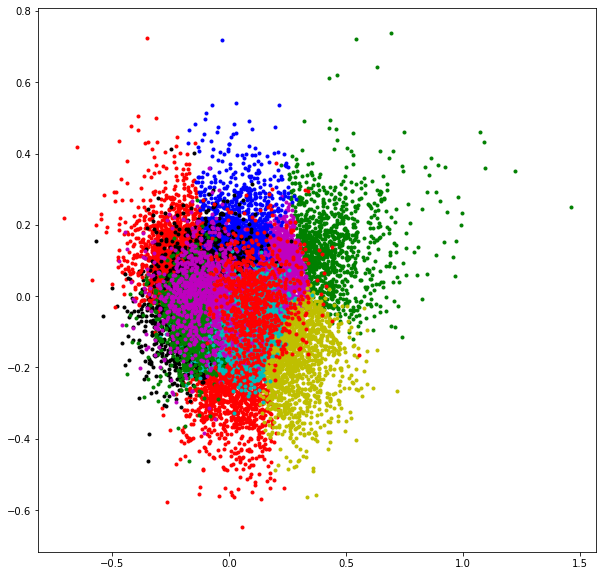

In [42]:
parse_results(km_pred, 'km')

In [20]:
centers = km_model.cluster_centers_

### SOM

In [43]:
from sklearn_som.som import SOM

In [44]:
%%time

som = SOM(m=4, n=4, dim=50)
som.fit(dataset_encoded)

CPU times: user 2.36 s, sys: 0 ns, total: 2.36 s
Wall time: 2.36 s


In [45]:
%%time

som_pred = som.predict(dataset_encoded)

CPU times: user 1.54 s, sys: 0 ns, total: 1.54 s
Wall time: 1.54 s


cluster 0 : 2812 messages
Les 20 mots les plus fréquents : faire français sale cest fils noir arabe france aller grand pouvoir bien an voir macron pays petit the devoir président 

cluster 1 : 2920 messages
Les 20 mots les plus fréquents : faire français pouvoir aller an voir bien france jour mettre noir novembre vouloir paris venir amp devoir falloir passer grand 

cluster 2 : 2239 messages
Les 20 mots les plus fréquents : français faire pouvoir france arabe aller dollar voir novembre bien in devoir an vote covid vouloir jour paris droite étranger 

cluster 3 : 2440 messages
Les 20 mots les plus fréquents : français faire france pouvoir pays an aller devoir étranger bien macron vaccin président grand vouloir covid politique vacciner voir falloir 

cluster 4 : 1956 messages
Les 20 mots les plus fréquents : sale faire noir cest arabe aller fils français voir pouvoir bien manifesting surprise dm pd vouloir petit mettre savoir gros 

cluster 5 : 5975 messages
Les 20 mots les plus fréquent

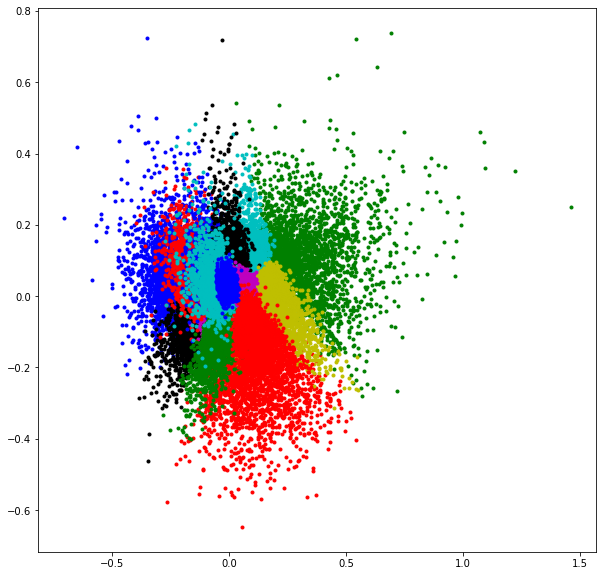

In [46]:
parse_results(som_pred, "som")

### DBSCAN

In [97]:
from sklearn.cluster import DBSCAN

In [98]:
%%time

dbscan_pred = DBSCAN().fit_predict(dataset_encoded)

CPU times: user 19min 7s, sys: 19.3 s, total: 19min 26s
Wall time: 19min 29s


cluster 0 : 4810 messages
cluster 1 : 7 messages
cluster 2 : 5 messages
cluster 3 : 8 messages
cluster 4 : 6 messages
cluster 5 : 6 messages
cluster 6 : 5 messages
cluster 7 : 5 messages
cluster 8 : 35 messages
cluster 9 : 7 messages
cluster 10 : 9 messages
cluster 11 : 6 messages
cluster 12 : 5 messages
cluster 13 : 18 messages
cluster 14 : 5 messages
cluster 15 : 5 messages
cluster 16 : 6 messages
cluster 17 : 6 messages
cluster 18 : 5 messages
cluster 19 : 5 messages
cluster 20 : 5 messages
cluster 21 : 6 messages
cluster 22 : 7 messages
cluster 23 : 10 messages
cluster 24 : 8 messages
Les 20 mots les plus fréquents du cluster 0 : a ça plus si quand fait faire tout cette être comme bien va trop tous quoi non là rt rien 

Les 20 mots les plus fréquents du cluster 1 : oui 

Les 20 mots les plus fréquents du cluster 2 : voilà 

Les 20 mots les plus fréquents du cluster 3 : merci 

Les 20 mots les plus fréquents du cluster 4 : yassification 

Les 20 mots les plus fréquents du cluster 5 

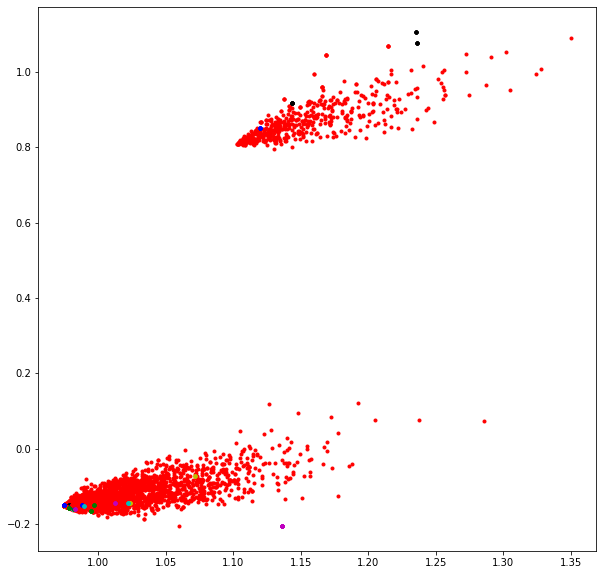

In [151]:
parse_results(dbscan_pred, "dbscan")

In [155]:
from sklearn.metrics import pairwise_distances

a = dataset_encoded[0]
b = dataset_encoded[1]

pairwise_distances(dataset_encoded)

array([[0.        , 5.38516481, 3.46410162, ..., 4.79583152, 3.87298335,
        3.60555128],
       [5.38516481, 0.        , 5.56776436, ..., 6.4807407 , 6.        ,
        5.83095189],
       [3.46410162, 5.56776436, 0.        , ..., 5.        , 4.35889894,
        4.12310563],
       ...,
       [4.79583152, 6.4807407 , 5.        , ..., 0.        , 5.47722558,
        5.29150262],
       [3.87298335, 6.        , 4.35889894, ..., 5.47722558, 0.        ,
        4.47213595],
       [3.60555128, 5.83095189, 4.12310563, ..., 5.29150262, 4.47213595,
        0.        ]])

### Affinity propagation

In [156]:
from sklearn.cluster import AffinityPropagation

In [157]:
%%time

AP_pred = AffinityPropagation().fit_predict(dataset_encoded)

CPU times: user 5min 8s, sys: 987 ms, total: 5min 9s
Wall time: 5min 9s


/home/victor/fidle/fidle-env/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


cluster 0 : 5000 messages
Les 20 mots les plus fréquents du cluster 0 : a ça plus si quand tout faire fait cette être comme bien va trop non tous quoi merci rt là 

cluster 0 (clé -1)
M. Pokora si les actes ne l’avait pas manqués https://t.co/Q7U9upiEjc

Le programme des équipes du CBB jouant à domicile samedi prochain #cherbourgbasketball #cherbourg #basket #CBB #championnat #matchs #region https://t.co/44W849jlGG

C'est une de nos qualités quand on est Army😌😌 tmtc




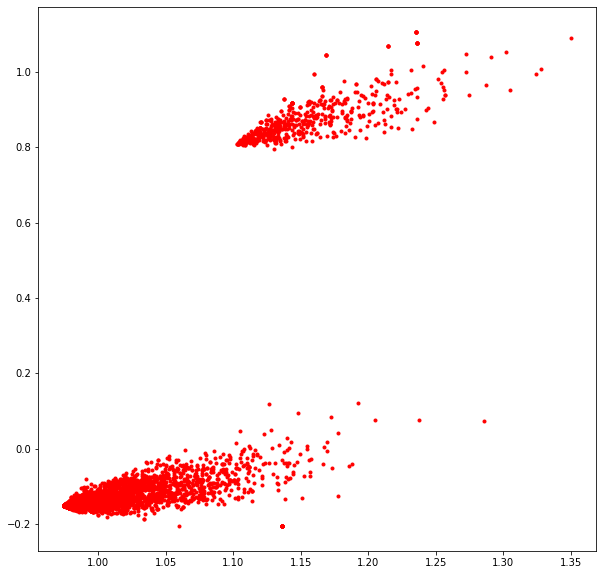

In [159]:
parse_results(AP_pred, "AP")